In [30]:
# Import Required Libraries
import os
import re
import json
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import torchvision.transforms as transforms
from PIL import Image

import timm

from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from rouge_score import rouge_scorer

import nltk
nltk.download('punkt')

from gtts import gTTS
from IPython.display import Audio
from deep_translator import GoogleTranslator

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [13]:
# Hyperparameters
batch_size = 128
embed_size = 768  
hidden_size = 768
num_layers = 2  
attention_dim = 512
learning_rate = 3e-4
num_epochs = 20
vocab_threshold = 2  

In [14]:
# Paths
dataset_name = "flickr8k"
images_dir = "/kaggle/input/flickr8k/Flickr_Data/Flickr_Data/Images"
captions_file = "/kaggle/input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"

In [15]:
# Transforms
# Training transform
train_transform = transforms.Compose([
    transforms.Resize(256),  # Resize to larger dimension
    transforms.RandomCrop(224),  # Random crop for augmentation
    transforms.RandomHorizontalFlip(0.5),  # Random flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transform
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
# Building Vocabulary

class Vocabulary:
    def __init__(self, vocab_threshold):
        self.vocab_threshold = vocab_threshold
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.add_word('<pad>')  # 0
        self.add_word('<start>')  # 1
        self.add_word('<end>')  # 2
        self.add_word('<unk>')  # 3
        
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
            
    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]
    
    def __len__(self):
        return len(self.word2idx)

def tokenize_caption(caption):
    """Improved tokenization with better cleaning"""
    # Convert to lowercase
    caption = caption.lower()
    # Keep periods for sentence structure but remove other punctuation
    caption = re.sub(r'[^\w\s\.]', '', caption)
    # Replace multiple spaces with single space
    caption = re.sub(r'\s+', ' ', caption)
    # Split by space
    return caption.strip().split()

def build_vocab(captions_file, dataset_name, vocab_threshold):
    counter = Counter()
    
    if dataset_name == "flickr8k":
        # For Flickr8k: Each line is formatted like: image_name#n\tcaption
        with open(captions_file, 'r') as f:
            for line in tqdm(f.readlines(), desc="Building vocabulary"):
                # Split by tab - first part is image name, second is caption
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    caption = parts[1].lower()
                    # Improved tokenization
                    tokens = tokenize_caption(caption)
                    counter.update(tokens)
    else:
        # COCO dataset
        with open(captions_file, 'r') as f:
            data = json.load(f)
        
        for annotation in tqdm(data['annotations'], desc="Building vocabulary"):
            caption = annotation['caption'].lower()
            tokens = tokenize_caption(caption)
            counter.update(tokens)
    
    # Filter words below threshold
    words = [word for word, cnt in counter.items() if cnt >= vocab_threshold]
    
    vocab = Vocabulary(vocab_threshold)
    for word in words:
        vocab.add_word(word)
    
    return vocab

In [17]:
# Fetching Captions
def get_captions_data(captions_file, dataset_name):
    image_captions = {}
    
    if dataset_name == "flickr8k":
        # For Flickr8k format
        with open(captions_file, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    # Extract image name (remove the #n suffix)
                    image_name = parts[0].split('#')[0]
                    caption = parts[1].lower()
                    tokens = tokenize_caption(caption)
                    caption = ' '.join(tokens)
                    
                    if image_name not in image_captions:
                        image_captions[image_name] = []
                    image_captions[image_name].append(caption)
    else:
        # COCO dataset
        with open(captions_file, 'r') as f:
            data = json.load(f)
        
        # Create image_id to filename mapping
        image_id_to_name = {}
        for img in data['images']:
            image_id_to_name[img['id']] = img['file_name']
        
        for annotation in data['annotations']:
            image_id = annotation['image_id']
            image_name = image_id_to_name[image_id]
            caption = annotation['caption'].lower()
            tokens = tokenize_caption(caption)
            caption = ' '.join(tokens)
            
            if image_name not in image_captions:
                image_captions[image_name] = []
            image_captions[image_name].append(caption)
    
    return image_captions

class ImageCaptionDataset(Dataset):
    def __init__(self, images_dir, image_captions, vocab, transform, split='train'):
        self.images_dir = images_dir
        self.vocab = vocab
        self.transform = transform
        
        # Split data into train/val with 80/20 split
        self.split = split
        image_names = list(image_captions.keys())
        random.shuffle(image_names)
        
        if split == 'train':
            self.image_names = image_names[:int(0.8 * len(image_names))]
        else:  # val
            self.image_names = image_names[int(0.8 * len(image_names)):]
        
        # For each image, use just one caption to avoid duplicating images
        self.captions = []
        self.image_paths = []
        
        for image_name in self.image_names:
            # FIX: For each image, use all captions - creates multiple instances
            image_captions_list = image_captions[image_name]
            image_path = os.path.join(images_dir, image_name)
            
            # Skip if file doesn't exist
            if not os.path.exists(image_path):
                continue
            
            for caption in image_captions_list:
                self.captions.append(caption)
                self.image_paths.append(image_path)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        caption = self.captions[idx]
        
        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        
        # Convert caption to tensor of indices
        tokens = caption.split()
        caption_vec = []
        caption_vec.append(self.vocab('<start>'))
        caption_vec.extend([self.vocab(token) for token in tokens])
        caption_vec.append(self.vocab('<end>'))
        caption_vec = torch.tensor(caption_vec, dtype=torch.long)
        
        return image, caption_vec
    
    def __len__(self):
        return len(self.captions)

def collate_fn(batch):
    """Sort batch by caption length (descending)"""
    # Sort by caption length
    batch.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*batch)
    
    # Stack images
    images = torch.stack(images, 0)
    
    # Get caption lengths
    lengths = [len(cap) for cap in captions]
    
    # Pad captions
    targets = pad_sequence(captions, batch_first=True, padding_value=0)
    
    return images, targets, lengths

In [18]:
# Defining Model

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        
        Args:
            encoder_out: encoded images, a tensor of dimension (batch_size, encoder_dim)
            decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        Returns:
            attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, 1)
        alpha = self.softmax(att)  # (batch_size, 1)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        
        return attention_weighted_encoding, alpha

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Load DeiT model using timm - use deit_base_patch16_224 for better feature extraction
        self.deit = timm.create_model('deit_base_patch16_224', pretrained=True)
        
        # Replace the classification head with an identity layer
        self.deit.head = nn.Identity()
        
        # FIX: Don't freeze all parameters - fine-tune the last few layers
        # Freeze only the first 8 layers
        for name, param in self.deit.named_parameters():
            if 'blocks.8' in name or 'blocks.9' in name or 'blocks.10' in name or 'blocks.11' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        # Project DeiT features to embedding size
        self.linear = nn.Linear(768, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)
        self.dropout = nn.Dropout(0.3)  # Reduced from 0.5
        
    def forward(self, images):
        # Forward pass through DeiT
        features = self.deit(images)
        
        # Linear projection
        features = self.linear(features)
        features = self.bn(features)
        features = self.dropout(features)
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, attention_dim=512):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.attention_dim = attention_dim
        
        # Word embeddings
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        # Attention network
        self.attention = Attention(embed_size, hidden_size, attention_dim)
        
        # LSTM cell
        self.lstm = nn.LSTM(embed_size + embed_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        
        # Output layers
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.3)
        
    def init_hidden_state(self, features):
        """Initialize hidden state and cell state."""
        h = self.init_h(features)
        h = h.repeat(self.num_layers, 1, 1)  # (num_layers, batch_size, hidden_size)
        
        c = self.init_c(features)
        c = c.repeat(self.num_layers, 1, 1)  # (num_layers, batch_size, hidden_size)
        
        return h, c
        
    def forward(self, features, captions, lengths):
        # Embed captions
        embeddings = self.embed(captions)
        
        # Initialize hidden and cell states
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)
        
        # Exclude the last word from captions (which should be <end>)
        decode_lengths = [l - 1 for l in lengths]
        
        # Create tensor to store outputs
        outputs = torch.zeros(batch_size, max(decode_lengths), self.vocab_size).to(device)
        
        # For each time step
        for t in range(max(decode_lengths)):
            # Keep only the relevant timesteps for each sequence
            batch_size_t = sum([l > t for l in decode_lengths])
            
            # Get the attention weighted encoding
            attention_weighted_encoding, alpha = self.attention(
                features[:batch_size_t].unsqueeze(1), h[0, :batch_size_t]
            )
            
            # Concatenate embedding and attention weighted encoding
            lstm_input = torch.cat(
                [embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1
            ).unsqueeze(1)
            
            # Pass through LSTM
            lstm_output, (h_t, c_t) = self.lstm(
                lstm_input,
                (h[:, :batch_size_t].contiguous(), c[:, :batch_size_t].contiguous())
            )
            h = h.clone()
            c = c.clone()
            h[:, :batch_size_t] = h_t
            c[:, :batch_size_t] = c_t


            
            # Apply dropout and compute output
            output = self.linear(self.dropout(lstm_output.squeeze(1)))
            outputs[:batch_size_t, t] = output
        
        return outputs
    
    def sample(self, features, max_len=20):
        """Generate captions using beam search."""
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)
        
        # Tensor to store sampled indices
        sampled_ids = []
        
        # Starting input - encode image features
        attention_weighted_encoding, alpha = self.attention(features.unsqueeze(1), h[0])
        
        # Start token
        input_word = torch.full((batch_size,), 1, dtype=torch.long).to(device)  # <start> token
        
        for i in range(max_len):
            # Embed the previous word
            embeddings = self.embed(input_word)
            
            # Get attention weighted encoding
            attention_weighted_encoding, alpha = self.attention(features.unsqueeze(1), h[0])
            
            # Concatenate embedding and attention weighted encoding
            lstm_input = torch.cat([embeddings, attention_weighted_encoding], dim=1).unsqueeze(1)
            
            # Forward pass through LSTM
            lstm_output, (h, c) = self.lstm(lstm_input, (h, c))
            outputs = self.linear(lstm_output.squeeze(1))
            
            # Predicted next word
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            
            # Update input word for next iteration
            input_word = predicted
            
            # Break if all sequences predict <end>
            if (predicted == 2).sum() == batch_size:
                break
        
        # Convert list of tensors to tensor
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids

In [19]:
# Model Training
def train_model(batch_size, embed_size, hidden_size, num_layers, attention_dim, learning_rate, num_epochs, vocab_threshold):
    # Build vocabulary
    print("Building vocabulary...")
    vocab = build_vocab(captions_file, dataset_name, vocab_threshold)
    print(f"Vocabulary size: {len(vocab)}")
    
    # Load captions data
    print("Loading captions data...")
    image_captions = get_captions_data(captions_file, dataset_name)
    print(f"Loaded {len(image_captions)} images with captions")
    
    # Create datasets and data loaders with proper transforms
    train_dataset = ImageCaptionDataset(images_dir, image_captions, vocab, train_transform, split='train')
    val_dataset = ImageCaptionDataset(images_dir, image_captions, vocab, val_transform, split='val')
    
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    
    # Check if the dataset is empty
    if len(train_dataset) == 0 or len(val_dataset) == 0:
        raise ValueError("Datasets are empty. Please check the paths to images and captions files.")
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2, 
        collate_fn=collate_fn,
        pin_memory=True  # Speed up data transfer to GPU
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2, 
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    # Initialize the models
    encoder = EncoderCNN(embed_size).to(device)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers, attention_dim).to(device)
    
    # Define loss function and optimizers
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
    
    # Use different learning rates for different components
    encoder_params = list(filter(lambda p: p.requires_grad, encoder.parameters()))
    decoder_params = list(decoder.parameters())
    
    optimizer = optim.AdamW([
        {'params': encoder_params, 'lr': learning_rate / 10},  # Lower learning rate for encoder
        {'params': decoder_params, 'lr': learning_rate}
    ], weight_decay=1e-5)  # Add weight decay for regularization
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', factor=0.5, patience=2, verbose=True
    )
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'bleu4': [],
        'rouge_l': []
    }
    
    # Create ROUGE scorer
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Track best model
    best_bleu4 = 0

    torch.autograd.set_detect_anomaly(True)
    
    # Training loop
    print("Starting training...")
    total_step = len(train_loader)
    
    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()
        
        train_loss = 0
        start_time = time.time()
        
        for i, (images, captions, lengths) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images = images.to(device)
            captions = captions.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            
            # Since we need to compare outputs with targets, we need to reshape them
            targets = captions[:, 1:]  # Exclude <start> token from targets
            
            # Create mask for valid timesteps (ignore padding)
            batch_size = features.size(0)
            decode_lengths = [l - 1 for l in lengths]
            mask = torch.zeros(outputs.size(0), outputs.size(1), dtype=torch.bool).to(device)
            for i, l in enumerate(decode_lengths):
                mask[i, :l] = 1
            
            # Calculate loss
            outputs = pack_padded_sequence(outputs, decode_lengths, batch_first=True, enforce_sorted=False).data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True, enforce_sorted=False).data
            
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(encoder_params + decoder_params, max_norm=5.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            
            # Print log info
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
        
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation
        encoder.eval()
        decoder.eval()
        val_loss = 0
        all_references = []
        all_hypotheses = []
        
        with torch.no_grad():
            for images, captions, lengths in tqdm(val_loader, desc="Validating"):
                images = images.to(device)
                captions = captions.to(device)
                
                # Forward pass
                features = encoder(images)
                outputs = decoder(features, captions, lengths)
                
                # Calculate validation loss
                targets = captions[:, 1:]
                
                # Create mask for valid timesteps
                batch_size = features.size(0)
                decode_lengths = [l - 1 for l in lengths]
                mask = torch.zeros(outputs.size(0), outputs.size(1), dtype=torch.bool).to(device)
                for i, l in enumerate(decode_lengths):
                    mask[i, :l] = 1
                
                # Calculate loss
                outputs_packed = pack_padded_sequence(outputs, decode_lengths, batch_first=True, enforce_sorted=False).data
                targets_packed = pack_padded_sequence(targets, decode_lengths, batch_first=True, enforce_sorted=False).data
                
                loss = criterion(outputs_packed, targets_packed)
                val_loss += loss.item()
                
                # Generate captions for BLEU and ROUGE scores
                sampled_ids = decoder.sample(features)
                
                # Convert word_ids to words
                sampled_captions = []
                for sampled_id in sampled_ids:
                    sampled_caption = []
                    for word_id in sampled_id:
                        word = vocab.idx2word[word_id.item()]
                        if word == '<end>':
                            break
                        if word not in ['<start>', '<pad>', '<unk>']:
                            sampled_caption.append(word)
                    sampled_captions.append(' '.join(sampled_caption))
                
                # Reference captions for BLEU
                reference_captions = []
                for cap in captions:
                    reference = []
                    for word_id in cap:
                        word = vocab.idx2word[word_id.item()]
                        if word == '<end>':
                            break
                        if word not in ['<start>', '<pad>', '<unk>']:
                            reference.append(word)
                    reference_captions.append(reference)
                
                # Prepare data for BLEU and ROUGE
                for i in range(len(sampled_captions)):
                    all_hypotheses.append(sampled_captions[i].split())
                    all_references.append([reference_captions[i]])
        
        # Calculate BLEU-4 score
        bleu4 = corpus_bleu(all_references, all_hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
        
        # Calculate ROUGE-L F1 score
        rouge_l_scores = []
        for ref, hyp in zip(all_references, all_hypotheses):
            rouge_score = rouge_scorer_obj.score(' '.join(ref[0]), ' '.join(hyp))
            rouge_l_scores.append(rouge_score['rougeL'].fmeasure)
        rouge_l = np.mean(rouge_l_scores)
        
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        history['bleu4'].append(bleu4)
        history['rouge_l'].append(rouge_l)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, BLEU-4: {bleu4:.4f}, ROUGE-L: {rouge_l:.4f}, '
              f'Time: {time.time() - start_time:.2f}s')
        
        # Save the best model
        if bleu4 > best_bleu4:
            best_bleu4 = bleu4
            print(f"New best model with BLEU-4: {bleu4:.4f}")
            
            # Save entire model
            torch.save({
                'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'bleu4': bleu4,
                'vocab': vocab
            }, 'best_model.pt')
    
    # Save final model
    torch.save({
        'epoch': num_epochs,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'vocab': vocab
    }, 'final_model.pt')
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    
    plt.subplot(1, 3, 2)
    plt.plot(history['bleu4'], label='BLEU-4')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('BLEU-4 Score')
    
    plt.subplot(1, 3, 3)
    plt.plot(history['rouge_l'], label='ROUGE-L')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('ROUGE-L Score')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    return encoder, decoder, vocab, history

In [20]:
def visualize_predictions(encoder, decoder, vocab, dataset, num_samples=5):
    """Visualize predictions for random images"""
    encoder.eval()
    decoder.eval()
    
    # Create a fixed set of sample indices for reproducibility
    indices = random.sample(range(len(dataset)), num_samples)
    
    plt.figure(figsize=(15, 20))
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, caption = dataset[idx]
            image = image.unsqueeze(0).to(device)
            
            # Generate caption
            features = encoder(image)
            sampled_ids = decoder.sample(features)[0]
            
            # Convert word_ids to words
            sampled_caption = []
            for word_id in sampled_ids:
                word = vocab.idx2word[word_id.item()]
                if word == '<end>':
                    break
                if word not in ['<start>', '<pad>', '<unk>']:
                    sampled_caption.append(word)
            predicted_caption = ' '.join(sampled_caption)
            
            # Original caption
            true_caption = []
            for word_id in caption:
                word = vocab.idx2word[word_id.item()]
                if word == '<end>':
                    break
                if word not in ['<start>', '<pad>', '<unk>']:
                    true_caption.append(word)
            actual_caption = ' '.join(true_caption)
            
            # Display image and captions
            plt.subplot(num_samples, 2, 2*i+1)
            img = image.cpu().squeeze(0).permute(1, 2, 0)
            # Denormalize the image
            img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            img = torch.clamp(img, 0, 1)
            plt.imshow(img)
            plt.title('Image')
            plt.axis('off')
            
            plt.subplot(num_samples, 2, 2*i+2)
            plt.text(0, 0.5, f'Predicted: {predicted_caption}', fontsize=12)
            plt.text(0, 0.3, f'Actual: {actual_caption}', fontsize=12)
            plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('prediction_visualization.png')
    plt.show()

No pre-trained model found. Training from scratch...
Building vocabulary...


Building vocabulary:   0%|          | 0/40460 [00:00<?, ?it/s]

Vocabulary size: 5225
Loading captions data...
Loaded 8092 images with captions
Training dataset size: 32360
Validation dataset size: 8095


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Starting training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 4.4365, Val Loss: 3.5153, BLEU-4: 0.0455, ROUGE-L: 0.2824, Time: 551.53s
New best model with BLEU-4: 0.0455


Epoch 2/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 3.3303, Val Loss: 3.0416, BLEU-4: 0.0636, ROUGE-L: 0.3163, Time: 569.75s
New best model with BLEU-4: 0.0636


Epoch 3/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 2.9796, Val Loss: 2.7743, BLEU-4: 0.0760, ROUGE-L: 0.3335, Time: 569.85s
New best model with BLEU-4: 0.0760


Epoch 4/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 2.7558, Val Loss: 2.5920, BLEU-4: 0.0834, ROUGE-L: 0.3524, Time: 571.14s
New best model with BLEU-4: 0.0834


Epoch 5/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 2.5892, Val Loss: 2.4499, BLEU-4: 0.0878, ROUGE-L: 0.3609, Time: 571.07s
New best model with BLEU-4: 0.0878


Epoch 6/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 2.4536, Val Loss: 2.3336, BLEU-4: 0.1025, ROUGE-L: 0.3765, Time: 568.42s
New best model with BLEU-4: 0.1025


Epoch 7/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 2.3354, Val Loss: 2.2341, BLEU-4: 0.1061, ROUGE-L: 0.3832, Time: 569.03s
New best model with BLEU-4: 0.1061


Epoch 8/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 2.2322, Val Loss: 2.1482, BLEU-4: 0.1100, ROUGE-L: 0.3895, Time: 569.05s
New best model with BLEU-4: 0.1100


Epoch 9/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 2.1371, Val Loss: 2.0636, BLEU-4: 0.1132, ROUGE-L: 0.3928, Time: 569.02s
New best model with BLEU-4: 0.1132


Epoch 10/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 2.0518, Val Loss: 1.9892, BLEU-4: 0.1186, ROUGE-L: 0.3988, Time: 569.06s
New best model with BLEU-4: 0.1186


Epoch 11/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 1.9722, Val Loss: 1.9269, BLEU-4: 0.1220, ROUGE-L: 0.4018, Time: 569.81s
New best model with BLEU-4: 0.1220


Epoch 12/20:   0%|          | 0/253 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d35aaa01a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d35aaa01a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 1.8949, Val Loss: 1.8611, BLEU-4: 0.1271, ROUGE-L: 0.4071, Time: 570.86s
New best model with BLEU-4: 0.1271


Epoch 13/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 1.8227, Val Loss: 1.8012, BLEU-4: 0.1305, ROUGE-L: 0.4110, Time: 580.52s
New best model with BLEU-4: 0.1305


Epoch 14/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 1.7547, Val Loss: 1.7416, BLEU-4: 0.1368, ROUGE-L: 0.4135, Time: 559.38s
New best model with BLEU-4: 0.1368


Epoch 15/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 1.6903, Val Loss: 1.6898, BLEU-4: 0.1403, ROUGE-L: 0.4185, Time: 570.69s
New best model with BLEU-4: 0.1403


Epoch 16/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 1.6310, Val Loss: 1.6426, BLEU-4: 0.1463, ROUGE-L: 0.4220, Time: 570.09s
New best model with BLEU-4: 0.1463


Epoch 17/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 1.5710, Val Loss: 1.5990, BLEU-4: 0.1497, ROUGE-L: 0.4252, Time: 569.26s
New best model with BLEU-4: 0.1497


Epoch 18/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 1.5153, Val Loss: 1.5569, BLEU-4: 0.1527, ROUGE-L: 0.4281, Time: 569.01s
New best model with BLEU-4: 0.1527


Epoch 19/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 1.4646, Val Loss: 1.5174, BLEU-4: 0.1565, ROUGE-L: 0.4318, Time: 570.30s
New best model with BLEU-4: 0.1565


Epoch 20/20:   0%|          | 0/253 [00:00<?, ?it/s]

Validating:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 1.4148, Val Loss: 1.4825, BLEU-4: 0.1539, ROUGE-L: 0.4301, Time: 568.09s


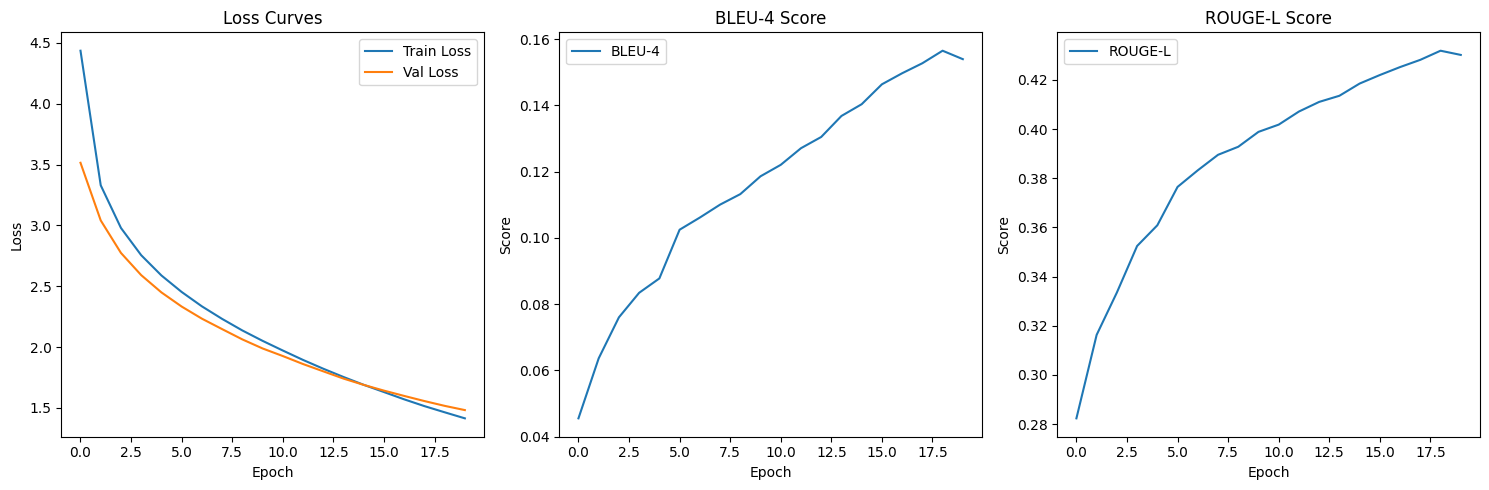

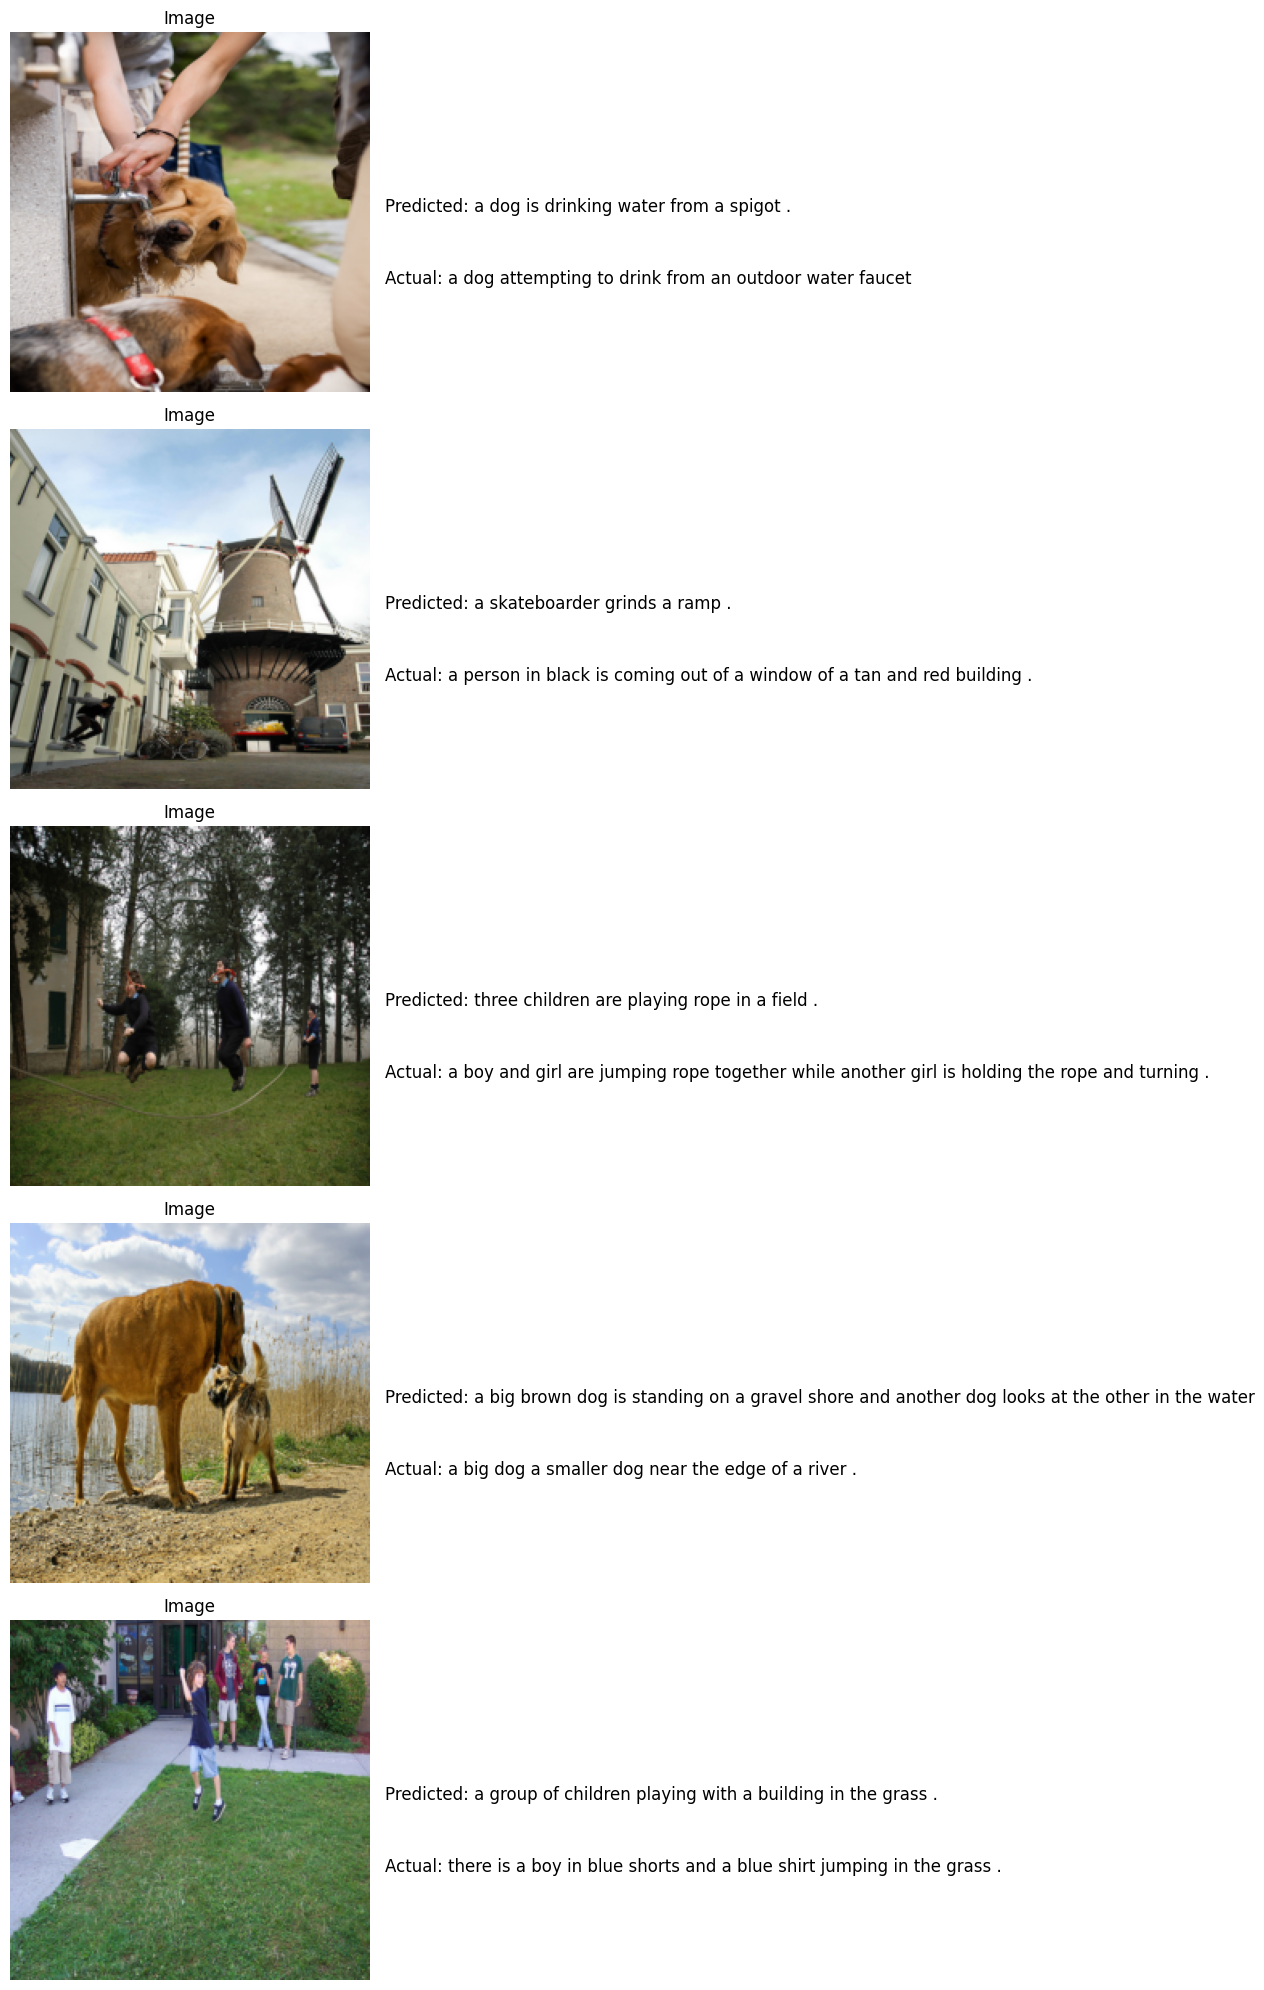

In [21]:
def main():
    # Check if saved model exists
    if os.path.exists('best_model.pt'):
        print("Loading pre-trained model...")
        checkpoint = torch.load('best_model.pt')
        
        # Rebuild the vocabulary
        vocab = checkpoint['vocab']
        
        # Initialize models
        encoder = EncoderCNN(embed_size).to(device)
        decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers, attention_dim).to(device)
        
        # Load states
        encoder.load_state_dict(checkpoint['encoder_state_dict'])
        decoder.load_state_dict(checkpoint['decoder_state_dict'])
        
        print(f"Model loaded from checkpoint (epoch {checkpoint['epoch']}, BLEU-4: {checkpoint.get('bleu4', 'N/A')})")
        
        # Load captions data
        image_captions = get_captions_data(captions_file, dataset_name)
        
        # Create validation dataset
        val_dataset = ImageCaptionDataset(images_dir, image_captions, vocab, val_transform, split='val')
        
        # Visualize some predictions
        visualize_predictions(encoder, decoder, vocab, val_dataset)
        
    else:
        print("No pre-trained model found. Training from scratch...")
        encoder, decoder, vocab, history = encoder, decoder, vocab, history = train_model(batch_size, embed_size, hidden_size, num_layers, attention_dim,
                                                                                          learning_rate, num_epochs, vocab_threshold)

        
        # Load captions data
        image_captions = get_captions_data(captions_file, dataset_name)
        
        # Create validation dataset
        val_dataset = ImageCaptionDataset(images_dir, image_captions, vocab, val_transform, split='val')
        
        # Visualize some predictions
        visualize_predictions(encoder, decoder, vocab, val_dataset)

if __name__ == '__main__':
    main()

In [32]:
!zip -r /kaggle/working/output.zip /kaggle/working/*

updating: kaggle/working/best_model.pt (deflated 8%)
updating: kaggle/working/final_model.pt (deflated 8%)
updating: kaggle/working/prediction_visualization.png (deflated 2%)
updating: kaggle/working/training_history.png (deflated 8%)
  adding: kaggle/working/caption_Chinese.mp3 (deflated 2%)
  adding: kaggle/working/caption_French.mp3 (deflated 3%)
  adding: kaggle/working/caption_German.mp3 (deflated 3%)
  adding: kaggle/working/caption_Hindi.mp3 (deflated 2%)
  adding: kaggle/working/caption_Spanish.mp3 (deflated 2%)


## Inference

In [22]:
def load_model(model_path, embed_size=768, hidden_size=768, num_layers=2, attention_dim=512):
    """Load the trained model"""
    # Check if model file exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract vocabulary from checkpoint
    vocab = checkpoint['vocab']
    
    # Initialize encoder and decoder
    encoder = EncoderCNN(embed_size).to(device)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers, attention_dim).to(device)
    
    # Load states
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    
    # Set to evaluation mode
    encoder.eval()
    decoder.eval()
    
    print(f"Model loaded from checkpoint (epoch {checkpoint['epoch']})")
    return encoder, decoder, vocab

In [23]:
# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class Vocabulary:
    """Vocabulary wrapper for handling word indexes"""
    def __init__(self, word2idx=None, idx2word=None):
        self.word2idx = word2idx if word2idx else {}
        self.idx2word = idx2word if idx2word else {}
    
    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx.get('<unk>', 3)  # Default <unk> token index is 3
        return self.word2idx[word]
    
    def __len__(self):
        return len(self.word2idx)

def generate_caption(image_path, encoder, decoder, vocab):
    """Generate caption for a given image"""
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    # Generate caption
    with torch.no_grad():
        features = encoder(image)
        sampled_ids = decoder.sample(features)[0]
        
        # Convert word_ids to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id.item()]
            if word == '<end>':
                break
            if word not in ['<start>', '<pad>', '<unk>']:
                sampled_caption.append(word)
        
        caption = ' '.join(sampled_caption)
    
    # Display image and caption
    plt.figure(figsize=(10, 8))
    img = image.cpu().squeeze(0).permute(1, 2, 0)
    # Denormalize the image
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = torch.clamp(img, 0, 1)
    plt.imshow(img)
    plt.title(f'Generated Caption: {caption}')
    plt.axis('off')
    plt.show()
    
    return caption

/tmp/ipykernel_31/1287141905.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Model loaded from checkpoint (epoch 18)


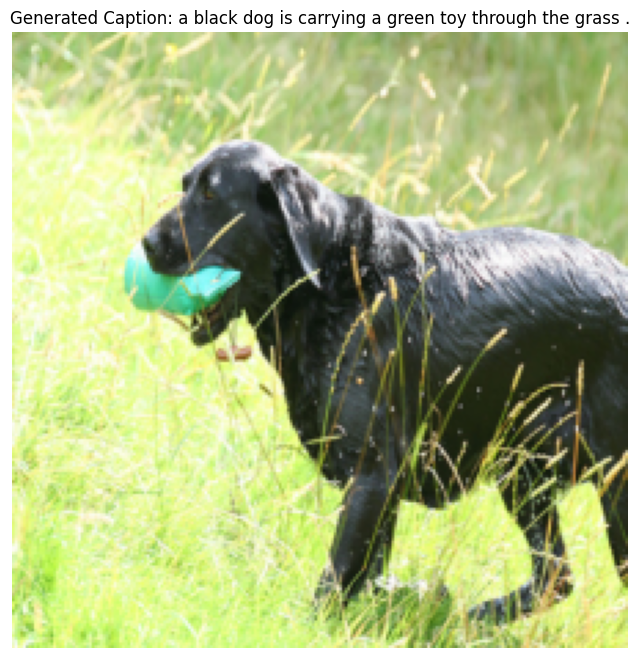

In [24]:
# Path to the saved model
model_path = '/kaggle/working/best_model.pt'  # Update this to your model path

# Load the model
encoder, decoder, vocab = load_model(model_path, embed_size, hidden_size, num_layers, attention_dim)


image_folder = '/kaggle/input/flickr8k/Flickr_Data/Flickr_Data/Images'
image_files = os.listdir(image_folder)
random_image_file = random.choice(image_files)
image_path = "/kaggle/input/flickr8k/Flickr_Data/Flickr_Data/Images/1026685415_0431cbf574.jpg"
caption = generate_caption(image_path, encoder, decoder, vocab)

In [25]:
languages = {
    'zh-CN': 'Chinese',
    'es': 'Spanish',
    'fr': 'French',
    'hi': 'Hindi',
    'de': 'German'
}

In [31]:
# Translate caption to each language and create audio
for lang_code, lang_name in languages.items():
    
    translated_text = GoogleTranslator(source='en', target=lang_code).translate(caption)
    
    # Generate audio file
    tts = gTTS(text=translated_text, lang=lang_code)
    audio_path = f'/kaggle/working/caption_{lang_name}.mp3'
    tts.save(audio_path)

    
    # Generate caption
    print(f"Generated caption: {caption}")

    print(f"{lang_name} caption: {translated_text}")
    print(f"Audio saved to: {audio_path}")

    display(Audio(audio_path))

Generated caption: a black dog is carrying a green toy through the grass .
Chinese caption: 一只黑狗在草地上载着绿色玩具。
Audio saved to: /kaggle/working/caption_Chinese.mp3


Generated caption: a black dog is carrying a green toy through the grass .
Spanish caption: Un perro negro lleva un juguete verde a través de la hierba.
Audio saved to: /kaggle/working/caption_Spanish.mp3


Generated caption: a black dog is carrying a green toy through the grass .
French caption: Un chien noir transporte un jouet vert à travers l'herbe.
Audio saved to: /kaggle/working/caption_French.mp3


Generated caption: a black dog is carrying a green toy through the grass .
Hindi caption: एक काला कुत्ता घास के माध्यम से एक हरे रंग का खिलौना ले जा रहा है।
Audio saved to: /kaggle/working/caption_Hindi.mp3


Generated caption: a black dog is carrying a green toy through the grass .
German caption: Ein schwarzer Hund trägt ein grünes Spielzeug durch das Gras.
Audio saved to: /kaggle/working/caption_German.mp3
